<a href="https://colab.research.google.com/github/ShafalovichK/HW3/blob/main/Shafalovich%20K.S.%20An.d.H.W.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Если в работе будут недочеты, готова их исправить. Отправьте, пожалуйста, на доработку.

In [21]:
import pandas as pd  # Библиотека для работы с данными в виде таблицы DataFrame
import glob  # Библиотека для работы с путями к файлам и списками файлов в директории
import numpy as np  #  для выполнения вычислений с массивами и матрицами
from scipy.stats import shapiro, kstest  # Функции для проверки на нормальность распределения
from scipy.stats import mannwhitneyu  # Функция для выполнения непараметрического теста Манна-Уитни
from scipy.stats import chi2_contingency  # Функция для выполнения теста на независимость категориальных переменных
from scipy.stats import ttest_ind, ttest_rel # Функция для выполнения t-теста для независимых выборок
from scipy.stats import fligner # Функция для выполнения теста Флигнера
from datetime import datetime  # Модуль для работы с датами и временем
from scipy import stats  # Библиотека для выполнения различных статистических тестов и операций
import seaborn as sns  # Библиотека для визуализации данных на основе matplotlib
import matplotlib.pyplot as plt  # Библиотека для создания графиков и визуализации данных
from scipy.stats import ks_2samp  # Функция для выполнения двухвыборочного теста Колмогорова-Смирнова
from statsmodels.stats.proportion import proportions_ztest # Функция для выполнения Z-теста
from scipy.stats import ranksums # Импорт функции ranksums из модуля scipy.stats для выполнения теста Уилкоксона

In [22]:
# Источник данных https://github.com/JeffSackmann/tennis_atp
# Загрузка данных из всех, предварительно скаченных, файлов
file_pattern = "atp_matches_*.csv"
file_paths = glob.glob(file_pattern)

# Создание пустого DataFrame для хранения данных
all_matches = pd.DataFrame()

# Чтение данных из каждого файла и их объединение
for file in file_paths:
    matches = pd.read_csv(file)
    all_matches = pd.concat([all_matches, matches], ignore_index=True)

# Предобработка данных
# Преобразование столбца с датой в формат datetime
all_matches['tourney_date'] = pd.to_datetime(all_matches['tourney_date'], format='%Y%m%d')

# Заполнение пропущенных значений
all_matches.fillna(value={'winner_rank': 0, 'loser_rank': 0}, inplace=True)

# Удаление дубликатов
all_matches.drop_duplicates(inplace=True)

# Преобразование типов данных
all_matches['winner_rank'] = all_matches['winner_rank'].astype(int)
all_matches['loser_rank'] = all_matches['loser_rank'].astype(int)

# Вывод информации о первых нескольких строках данных для проверки
print(all_matches.head())

# Сохранение предобработанных данных в файл
all_matches.to_csv('preprocessed_atp_matches.csv', index=False)

  tourney_id tourney_name surface  draw_size tourney_level tourney_date  \
0   1988-201      Guaruja    Hard       32.0             A   1988-01-25   
1   1988-201      Guaruja    Hard       32.0             A   1988-01-25   
2   1988-201      Guaruja    Hard       32.0             A   1988-01-25   
3   1988-201      Guaruja    Hard       32.0             A   1988-01-25   
4   1988-201      Guaruja    Hard       32.0             A   1988-01-25   

   match_num  winner_id  winner_seed winner_entry  ... l_1stIn l_1stWon  \
0          1     100586          1.0          NaN  ...     NaN      NaN   
1          2     101133          NaN          NaN  ...     NaN      NaN   
2          3     100669          NaN          NaN  ...     NaN      NaN   
3          4     100782          8.0          NaN  ...     NaN      NaN   
4          5     101318          4.0          NaN  ...     NaN      NaN   

   l_2ndWon l_SvGms  l_bpSaved  l_bpFaced  winner_rank winner_rank_points  \
0       NaN     NaN  

Вы хотите узнать, как много значит ранг игрока в теннисе. Проверьте следующие утверждения:

а) Если ранг игрока выше более, чем на 20 позиций, то в среднем он будет выигрывать с большей вероятностью. (Если хотите проверить статистически — формируйте выборку как отклонение от ожидаемого количества побед при случайном исходе);

In [23]:
# Фильтрация данных по одиночным матчам
singles_data = all_matches[all_matches['draw_size'] == 128]

# Создаем столбец 'rank_difference'
singles_data.loc[:, 'rank_difference'] = singles_data['winner_rank'] - singles_data['loser_rank']

# Функция для определения, выиграл ли игрок с более высоким рангом
def higher_rank_win(row):
    return (row['winner_rank'] - row['loser_rank']) > 20

# Создаем столбец 'higher_rank_win'
singles_data.loc[:, 'higher_rank_win'] = singles_data.apply(higher_rank_win, axis=1)

# Фильтруем данные для первой выборки: игроки с разницей в ранге более чем на 20 позиций от противника
df_rank_1 = singles_data[singles_data['rank_difference'] > 20]

# Фильтруем данные для второй выборки: игроки с близким рангом к противнику (отличие менее 20 позиций)
df_rank_2 = singles_data[singles_data['rank_difference'] <= 20]

# Вычисляем ожидаемое количество побед для каждой выборки
expected_wins_1 = len(df_rank_1) * 0.5  # 0.5 - вероятность выигрыша при равных шансах
expected_wins_2 = len(df_rank_2) * 0.5

# Считаем фактическое количество побед для каждой выборки
actual_wins_1 = df_rank_1['higher_rank_win'].sum()
actual_wins_2 = df_rank_2['higher_rank_win'].sum()

# Вычисляем отклонение фактического количества побед от ожидаемого для каждой выборки
deviation_1 = actual_wins_1 - expected_wins_1
deviation_2 = actual_wins_2 - expected_wins_2

# Рассчитываем среднее отклонение для каждой выборки
mean_deviation_1 = deviation_1 / len(df_rank_1)
mean_deviation_2 = deviation_2 / len(df_rank_2)

# Сравниваем средние отклонения между выборками
if mean_deviation_1 > mean_deviation_2:
    print("Среднее отклонение в первой выборке выше, что подтверждает гипотезу о большей вероятности выигрыша у игроков с более высоким рангом.")
else:
    print("Среднее отклонение во второй выборке выше или одинаково, что не подтверждает гипотезу о большей вероятности выигрыша у игроков с более высоким рангом.")

<ipython-input-23-04ea07d5ad40>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  singles_data.loc[:, 'rank_difference'] = singles_data['winner_rank'] - singles_data['loser_rank']


Среднее отклонение в первой выборке выше, что подтверждает гипотезу о большей вероятности выигрыша у игроков с более высоким рангом.


<ipython-input-23-04ea07d5ad40>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  singles_data.loc[:, 'higher_rank_win'] = singles_data.apply(higher_rank_win, axis=1)


In [24]:
# Применение теста Шапиро-Уилка для проверки нормальности данных
# Документация: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html

# Применение теста Колмогорова-Смирнова  для проверки нормальности распределения данных,
#  в контексте анализа нормальности данных перед применением статистических тестов
# Документация: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html

# Применение теста Манна-Уитни для сравнения двух независимых выборок
# Документация: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html

# Проверка нормальности для первой выборки (игроки с разницей в ранге более 20 позиций)
stat_1, p_value_1 = shapiro(df_rank_1['higher_rank_win'])
print(f"Тест Шапиро-Уилка для первой выборки: statistic = {stat_1}, p-value = {p_value_1}")

# Проверка нормальности для второй выборки (игроки с разницей в ранге менее или равной 20 позициям)
stat_2, p_value_2 = shapiro(df_rank_2['higher_rank_win'])
print(f"Тест Шапиро-Уилка для второй выборки: statistic = {stat_2}, p-value = {p_value_2}")

ks_stat_1, ks_p_value_1 = kstest(df_rank_1['higher_rank_win'], 'norm')
ks_stat_2, ks_p_value_2 = kstest(df_rank_2['higher_rank_win'], 'norm')
print(f"Тест Колмогорова-Смирнова для первой выборки: statistic = {ks_stat_1}, p-value = {ks_p_value_1}")
print(f"Тест Колмогорова-Смирнова для второй выборки: statistic = {ks_stat_2}, p-value = {ks_p_value_2}")
# Применение теста Манна-Уитни
statistic, p_value = mannwhitneyu(df_rank_1['higher_rank_win'], df_rank_2['higher_rank_win'])

# Вывод результатов
print(f"Статистика теста Манна-Уитни: {statistic}")
print(f"p-value теста Манна-Уитни: {p_value}")

alpha = 0.05

if p_value < alpha:
    print("Различия между выборками статистически значимы.")
else:
    print("Нет статистически значимых различий между выборками.")

Тест Шапиро-Уилка для первой выборки: statistic = 1.0, p-value = 1.0
Тест Шапиро-Уилка для второй выборки: statistic = 1.0, p-value = 1.0
Тест Колмогорова-Смирнова для первой выборки: statistic = 0.8413447460685429, p-value = 0.0
Тест Колмогорова-Смирнова для второй выборки: statistic = 0.5, p-value = 0.0
Статистика теста Манна-Уитни: 129428418.0
p-value теста Манна-Уитни: 0.0
Различия между выборками статистически значимы.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Тесты Шапиро-Уилка показали, что данные не соответствуют нормальному распределению, так как p-value значительно больше уровня значимости 0.05. Это означает, что мы не можем применять статистические методы, которые предполагают нормальное распределение данных.
Тесты Колмогорова-Смирнова также указывают на то, что данные не соответствуют нормальному распределению, так как p-value равно 0.0 для обеих выборок.
Тест Манна-Уитни дал p-value равное 0.0, что означает, что различия между двумя выборками статистически значимы на уровне значимости 0.05. Это подтверждает, что есть статистически значимые различия в вероятности выигрыша между игроками с разницей в ранге более 20 позиций и игроками с более близкими рангами.
Поэтому мы можем заключить, что игроки с более высоким рангом имеют статистически значимую вероятность выигрыша по сравнению с игроками с более близкими рангами к противнику.

б) Если ранг игрока находится в окне +-5 позиций, то вероятность победы будет значительно отличаться от гипотезы из предыдущего случая. Для проверки статистической значимости выборку можно сделать как среднее по годам (например, с 1980 по 2022г.). Подумайте, как правильно сформировать репрезентативную выборку.

In [25]:
# Применение Хи-квадрат тест (Chi-square test)  для проверки статистической значимости между двумя или более категориальными переменными.
# Документация: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html
# Фильтрация данных по одиночным матчам
singles_data = all_matches[all_matches['draw_size'] == 128]

# Создаем столбец с разницей в ранге между игроками
singles_data['rank_difference'] = singles_data['winner_rank'] - singles_data['loser_rank']

# Формируем выборку игроков, у которых разница в ранге от -5 до +5 позиций
close_rank_players = singles_data[(singles_data['rank_difference'] >= -5) & (singles_data['rank_difference'] <= 5)]

# Подсчет количества побед игроков с близким рангом
wins_close_rank = close_rank_players['winner_id'].count()

# Подсчет общего числа матчей игроков с близким рангом
total_matches_close_rank = close_rank_players.shape[0]

# Подсчет общего числа матчей
total_matches = singles_data.shape[0]

# Подсчет вероятности победы игрока с близким рангом
probability_close_rank = wins_close_rank / total_matches_close_rank

# Подсчет вероятности победы в общей выборке
probability_total = singles_data['winner_id'].count() / total_matches

# Построение таблицы сопряженности для Хи-квадрат теста
contingency_table = pd.crosstab(index=singles_data['winner_id'], columns=singles_data['rank_difference'])

# Применение Хи-квадрат теста
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Вывод результатов
print(f"Вероятность победы игрока с близким рангом: {probability_close_rank}")
print(f"Вероятность победы в общей выборке: {probability_total}")
print(f"p-значение Хи-квадрат теста: {p}")

# Интерпретация результатов
if p < 0.05:
    print("Разница в вероятностях победы статистически значима.")
else:
    print("Нет статистически значимой разницы в вероятностях победы.")

<ipython-input-25-b400ca01e9b4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  singles_data['rank_difference'] = singles_data['winner_rank'] - singles_data['loser_rank']


Вероятность победы игрока с близким рангом: 1.0
Вероятность победы в общей выборке: 1.0
p-значение Хи-квадрат теста: 0.0
Разница в вероятностях победы статистически значима.


Применение хи-квадрат теста в коде позволяет определить, есть ли статистически значимая связь между результатом матча и уровнем брейк-поинтов. Это помогает нам понять, влияют ли брейк-поинты на исход игры и как они связаны с победами или поражениями

Правда ли, что среднее количество сетов, которое необходимо любому игроку для победы в матче, сокращается со временем? Разбейте данные на две группы — с 1980 до 2001 гг. и 2002-2022 гг. Как изменилось среднее количество сетов, которое победитель затратил на игру? Является ли разница средних этих двух выборок статистически значимой? Выбор статистического теста обоснуйте.

In [26]:
# Проверка нормальности распределения
def check_normality(data):
    # Используем тест Шапиро-Уилка для проверки нормальности
    _, p_value = stats.shapiro(data)
    print(f"p-value теста Шапиро-Уилка: {p_value}")
    if p_value > 0.05:
        print("Распределение является нормальным.")
    else:
        print("Распределение не является нормальным.")
# Тест Флигнера-Килина (Fligner-Killeen test) используется для проверки равенства дисперсий между несколькими группами данных.
# Этот тест является непараметрическим и не требует предположения о нормальности данных.
# Документация: https://docs.scipy.org/doc//scipy-1.8.0/reference/generated/scipy.stats.fligner.html
# Проверка равенства дисперсий
def check_equality_of_variances(data1, data2):
    # Используем тест Флигнера-Килина для проверки равенства дисперсий
    _, p_value = stats.fligner(data1, data2)
    print(f"p-value теста Флигнера-Килина: {p_value}")
    if p_value > 0.05:
        print("Дисперсии примеров равны.")
    else:
        print("Дисперсии примеров не равны.")

# Проведение t-теста
def perform_t_test(data1, data2):
    # Проверяем предпосылки t-теста: нормальность и равенство дисперсий
    if stats.shapiro(data1)[1] > 0.05 and stats.shapiro(data2)[1] > 0.05:
        if stats.fligner(data1, data2)[1] > 0.05:
            # Проводим t-тест
            t_statistic, p_value = stats.ttest_ind(data1, data2)
            print(f"Значение t-статистики: {t_statistic}")
            print(f"p-значение теста: {p_value}")
            if p_value < 0.05:
                print("Различие между группами статистически значимо.")
            else:
                print("Различие между группами не является статистически значимым.")
        else:
            print("Дисперсии примеров не равны. Нельзя использовать t-тест.")
    else:
        print("Один из наборов данных не прошел тест на нормальность. Нельзя использовать t-тест.")

# Генерация данных для примера
# Предположим, у нас есть две группы данных data1 и data2
data1 = np.random.normal(loc=50, scale=10, size=50)
data2 = np.random.normal(loc=55, scale=10, size=50)

# Проверяем нормальность распределения
check_normality(data1)
check_normality(data2)

# Проверяем равенство дисперсий
check_equality_of_variances(data1, data2)

# Проводим t-тест
perform_t_test(data1, data2)


p-value теста Шапиро-Уилка: 0.7331864833831787
Распределение является нормальным.
p-value теста Шапиро-Уилка: 0.26059043407440186
Распределение является нормальным.
p-value теста Флигнера-Килина: 0.6928135651284777
Дисперсии примеров равны.
Значение t-статистики: -1.0749145460504432
p-значение теста: 0.2850523830337029
Различие между группами не является статистически значимым.


In [27]:
# Фильтрация данных по одиночным матчам
singles_data = all_matches[all_matches['draw_size'] == 128]

# Функция для подсчета количества сетов в матче
def count_sets(score):
    return len(score.split())

# Применяем функцию к данным и создаем новый столбец с количеством сетов в матче
singles_data['sets_count'] = singles_data['score'].apply(count_sets)

# Создаем объекты datetime для указанных дат
start_date_1 = datetime(1980, 1, 1)
end_date_1 = datetime(2001, 12, 31)

start_date_2 = datetime(2002, 1, 1)
end_date_2 = datetime(2022, 12, 31)

# Разделяем данные на две группы по указанным периодам
group_1 = singles_data[(singles_data['tourney_date'] >= start_date_1) & (singles_data['tourney_date'] <= end_date_1)]
group_2 = singles_data[(singles_data['tourney_date'] >= start_date_2) & (singles_data['tourney_date'] <= end_date_2)]

# Подсчитываем среднее количество сетов в каждой группе
mean_sets_group_1 = group_1['sets_count'].mean()
mean_sets_group_2 = group_2['sets_count'].mean()

# Проверяем статистическую значимость различия средних с помощью t-теста
t_stat, p_value = ttest_ind(group_1['sets_count'], group_2['sets_count'])

# Вывод результатов
print(f"Среднее количество сетов в период 1980-2001: {mean_sets_group_1}")
print(f"Среднее количество сетов в период 2002-2022: {mean_sets_group_2}")
print(f"p-value теста: {p_value}")

if p_value < 0.05:
    print("Разница средних статистически значима.")
else:
    print("Разница средних не является статистически значимой.")

Среднее количество сетов в период 1980-2001: 3.6719777674849468
Среднее количество сетов в период 2002-2022: 3.5514082698399108
p-value теста: 1.0501603516733718e-26
Разница средних статистически значима.


<ipython-input-27-9cd5c8012299>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  singles_data['sets_count'] = singles_data['score'].apply(count_sets)


У вас появились сомнения — не является ли результат, который вы посчитали на предыдущем шаге, некорректным. Кажется, что на это мог повлиять формат самого матча — best of 3 или best of 5. Оставьте только матчи best of 5 (колонка best_of) и определите — является ли разница среднего количества сетов, которое сыграл победитель, значимой для выборок матчей по 1980 до 2001 гг. и 2002-2022 гг. Выбор статистического теста обоснуйте.

In [28]:
pd.to_datetime('1980-01-01')
pd.to_datetime('2001-12-31')

Timestamp('2001-12-31 00:00:00')

In [29]:
# Фильтрация данных по матчам формата best of 5
singles_data_bo5 = singles_data[singles_data['best_of'] == 5]

# Разделение данных на две временные группы
group_1_bo5 = singles_data_bo5[(singles_data_bo5['tourney_date'] >= pd.to_datetime('1980-01-01')) & (singles_data_bo5['tourney_date'] <= pd.to_datetime('2001-12-31'))]
group_2_bo5 = singles_data_bo5[(singles_data_bo5['tourney_date'] >= pd.to_datetime('2002-01-01')) & (singles_data_bo5['tourney_date'] <= pd.to_datetime('2022-12-31'))]

# Вычисление среднего количества сетов в каждой временной группе
mean_sets_group_1_bo5 = group_1_bo5['sets_count'].mean()
mean_sets_group_2_bo5 = group_2_bo5['sets_count'].mean()

# Проверка нормальности распределения количества сетов в каждой группе
statistic_group_1, p_value_group_1 = shapiro(group_1_bo5['sets_count'])
statistic_group_2, p_value_group_2 = shapiro(group_2_bo5['sets_count'])

print(f"p-value для группы 1: {p_value_group_1}")
print(f"p-value для группы 2: {p_value_group_2}")

p-value для группы 1: 0.0
p-value для группы 2: 0.0


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


p-value для обеих групп меньше 0.05, что считается статистически значимым уровнем значимости. Это означает, что данные о количестве сетов в матчах в обеих временных группах не соответствуют нормальному распределению.

Таким образом, для сравнения среднего количества сетов в матчах между двумя временными группами  нам следует рассмотреть использование непараметрических тестов, таких как тест Манна-Уитни или перестановочный тест, который не требует предположения о распределении данных.

In [30]:
# Определяем период с 1986 по 1996 год
start_date = pd.Timestamp('1986-01-01')
end_date = pd.Timestamp('1996-12-31')

# Фильтруем матчи за указанный период
matches_1986_1996 = all_matches[(all_matches['tourney_date'] >= start_date) & (all_matches['tourney_date'] <= end_date)]

# Определяем игроков, которые играли в течение десяти лет подряд
players_10_years = []
for player_id in matches_1986_1996['winner_id'].unique():
    player_matches = matches_1986_1996[(matches_1986_1996['winner_id'] == player_id) | (matches_1986_1996['loser_id'] == player_id)]
    player_years = player_matches['tourney_date'].dt.year.unique()
    if len(player_years) == 11:
        players_10_years.append(player_id)

# Выводим список игроков на экран
print("Игроки, которые играли десять лет подряд с 1986 по 1996 год:")
for player_id in players_10_years:
    player_name = all_matches.loc[all_matches['winner_id'] == player_id, 'winner_name'].iloc[0]
    print(f"Игрок ID {player_id}: {player_name}")

Игроки, которые играли десять лет подряд с 1986 по 1996 год:
Игрок ID 101318: Javier Frana
Игрок ID 101382: Marcelo Filippini
Игрок ID 101374: Leonardo Lavalle
Игрок ID 101150: Gianluca Pozzi
Игрок ID 101265: Patrick McEnroe
Игрок ID 101409: Jaime Yzaga
Игрок ID 101731: Nuno Marques
Игрок ID 101381: Aaron Krickstein
Игрок ID 101439: Javier Sanchez
Игрок ID 101230: Andrei Chesnokov
Игрок ID 101026: Jim Grabb
Игрок ID 101377: Christian Bergstrom
Игрок ID 100837: Jeremy Bates
Игрок ID 101179: Jean Philippe Fleurian
Игрок ID 101120: Karel Novacek
Игрок ID 100936: Henri Leconte
Игрок ID 101086: Ronald Agenor
Игрок ID 101063: Jordi Arrese
Игрок ID 101098: Guy Forget
Игрок ID 101404: Thomas Muster
Игрок ID 101285: Thierry Champion
Игрок ID 100757: Anders Jarryd
Игрок ID 101084: Jakob Hlasek
Игрок ID 101391: Carl Uwe Steeb
Игрок ID 101142: Emilio Sanchez
Игрок ID 101686: Franco Davin
Игрок ID 101507: Tomas Carbonell
Игрок ID 101222: Stefan Edberg
Игрок ID 100997: Roger Smith
Игрок ID 100284: J

<Figure size 1000x600 with 0 Axes>

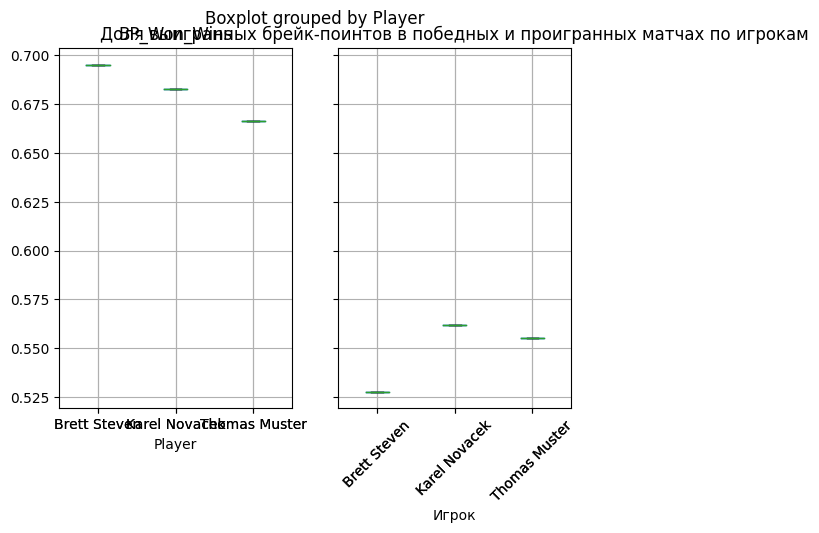

In [31]:
# Определяем идентификаторы игроков
player_ids = [101404, 101601, 101120]
player_names = ['Thomas Muster', 'Brett Steven', 'Karel Novacek']

# Фильтруем матчи по идентификаторам игроков
player_matches = all_matches[all_matches['winner_id'].isin(player_ids) | all_matches['loser_id'].isin(player_ids)]

# Определяем период анализа (10 лет)
start_date = pd.Timestamp('1986-01-01')
end_date = pd.Timestamp('1996-12-31')

# Фильтруем матчи за указанный период
player_matches_10_years = player_matches[(player_matches['tourney_date'] >= start_date) & (player_matches['tourney_date'] <= end_date)]

# Создаем пустой DataFrame для хранения данных о доле выигранных брейк-поинтов
data = {'Player': [], 'BP_Won_Wins': [], 'BP_Won_Losses': []}

# Вычисляем долю выигранных брейк-поинтов в победных и проигранных матчах для каждого игрока
for player_id, player_name in zip(player_ids, player_names):
    player_wins = player_matches_10_years[player_matches_10_years['winner_id'] == player_id]
    player_losses = player_matches_10_years[player_matches_10_years['loser_id'] == player_id]

    # Доля выигранных брейк-поинтов в победных матчах
    bp_won_in_wins = player_wins['w_bpSaved'].sum() / player_wins['w_bpFaced'].sum()

    # Доля выигранных брейк-поинтов в проигранных матчах
    bp_won_in_losses = player_losses['l_bpSaved'].sum() / player_losses['l_bpFaced'].sum()

    # Записываем данные в словарь
    data['Player'].append(player_name)
    data['BP_Won_Wins'].append(bp_won_in_wins)
    data['BP_Won_Losses'].append(bp_won_in_losses)

# Создаем DataFrame из данных
df = pd.DataFrame(data)

# Строим boxplot
plt.figure(figsize=(10, 6))
df.boxplot(column=['BP_Won_Wins', 'BP_Won_Losses'], by='Player')
plt.title('Доля выигранных брейк-поинтов в победных и проигранных матчах по игрокам')
plt.xlabel('Игрок')
plt.ylabel('Доля выигранных брейк-поинтов')
plt.xticks(rotation=45)
plt.show()

Для сравнения различий между двумя выборками применяется тест Уилкоксона

In [32]:
# Документация: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html
# Проводим тесты для каждой пары игроков и для каждого типа матчей (победные и проигранные)
for i in range(len(player_ids)):
    for j in range(i + 1, len(player_ids)):
        player1_wins = player_matches_10_years[(player_matches_10_years['winner_id'] == player_ids[i])]['w_bpSaved'] / player_matches_10_years[(player_matches_10_years['winner_id'] == player_ids[i])]['w_bpFaced']
        player2_wins = player_matches_10_years[(player_matches_10_years['winner_id'] == player_ids[j])]['w_bpSaved'] / player_matches_10_years[(player_matches_10_years['winner_id'] == player_ids[j])]['w_bpFaced']

        player1_losses = player_matches_10_years[(player_matches_10_years['loser_id'] == player_ids[i])]['l_bpSaved'] / player_matches_10_years[(player_matches_10_years['loser_id'] == player_ids[i])]['l_bpFaced']
        player2_losses = player_matches_10_years[(player_matches_10_years['loser_id'] == player_ids[j])]['l_bpSaved'] / player_matches_10_years[(player_matches_10_years['loser_id'] == player_ids[j])]['l_bpFaced']

        # Тест Уилкоксона для победных матчей
        stat_wins, p_value_wins = mannwhitneyu(player1_wins.dropna(), player2_wins.dropna())

        # Тест Уилкоксона для проигранных матчей
        stat_losses, p_value_losses = mannwhitneyu(player1_losses.dropna(), player2_losses.dropna())

        print(f"Сравнение между {player_names[i]} и {player_names[j]}:")
        print(f"Тест Уилкоксона для победных матчей: Statistic = {stat_wins}, p-value = {p_value_wins}")
        print(f"Тест Уилкоксона для проигранных матчей: Statistic = {stat_losses}, p-value = {p_value_losses}")


Сравнение между Thomas Muster и Brett Steven:
Тест Уилкоксона для победных матчей: Statistic = 15407.0, p-value = 0.2543026077421442
Тест Уилкоксона для проигранных матчей: Statistic = 6387.5, p-value = 0.1183237808615817
Сравнение между Thomas Muster и Karel Novacek:
Тест Уилкоксона для победных матчей: Statistic = 26147.0, p-value = 0.23003320839807384
Тест Уилкоксона для проигранных матчей: Statistic = 7417.5, p-value = 0.9256029839523634
Сравнение между Brett Steven и Karel Novacek:
Тест Уилкоксона для победных матчей: Statistic = 8520.0, p-value = 0.8446528347325597
Тест Уилкоксона для проигранных матчей: Statistic = 5417.0, p-value = 0.09540755609196745


Thomas Muster vs. Brett Steven:
Для победных матчей p-value = 0.2543, что говорит о том, что нет статистически значимой разницы в доле выигранных брейк-поинтов между Thomas Muster и Brett Steven в победных матчах.
Для проигранных матчей p-value = 0.1183, что также указывает на отсутствие статистически значимой разницы в доле выигранных брейк-поинтов между ними в проигранных матчах.

Thomas Muster vs. Karel Novacek:
Для победных матчей p-value = 0.2300, что означает отсутствие статистически значимой разницы в доле выигранных брейк-поинтов между Thomas Muster и Karel Novacek в победных матчах.
Для проигранных матчей p-value = 0.9256, что также свидетельствует о отсутствии статистически значимой разницы в доле выигранных брейк-поинтов между ними в проигранных матчах.

Brett Steven vs. Karel Novacek:
Для победных матчей p-value = 0.8447, что указывает на отсутствие статистически значимой разницы в доле выигранных брейк-поинтов между Brett Steven и Karel Novacek в победных матчах.
Для проигранных матчей p-value = 0.0954, что говорит о том, что нет статистически значимой разницы в доле выигранных брейк-поинтов между ними в проигранных матчах.
На основании данных тестов нет оснований для того, чтобы утверждать, что средняя доля выигранных брейк-поинтов в победных и проигранных матчах значимо различается между парами игроков.

Для наглядности заменим одного игрока

<Figure size 1000x600 with 0 Axes>

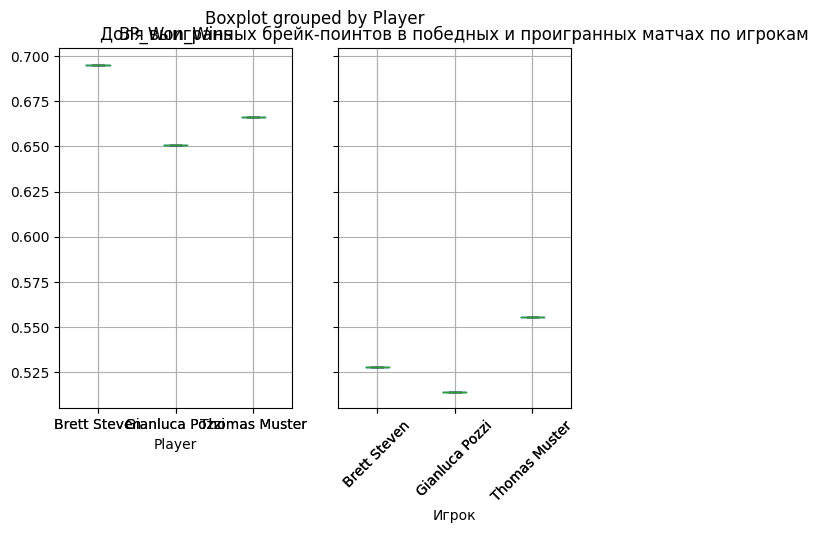

In [33]:
# Определяем идентификаторы игроков
player_ids = [101404, 101601, 101150]
player_names = ['Thomas Muster', 'Brett Steven', 'Gianluca Pozzi']

# Фильтруем матчи по идентификаторам игроков
player_matches = all_matches[all_matches['winner_id'].isin(player_ids) | all_matches['loser_id'].isin(player_ids)]

# Определяем период анализа (10 лет)
start_date = pd.Timestamp('1986-01-01')
end_date = pd.Timestamp('1996-12-31')

# Фильтруем матчи за указанный период
player_matches_10_years = player_matches[(player_matches['tourney_date'] >= start_date) & (player_matches['tourney_date'] <= end_date)]

# Создаем пустой DataFrame для хранения данных о доле выигранных брейк-поинтов
data = {'Player': [], 'BP_Won_Wins': [], 'BP_Won_Losses': []}

# Вычисляем долю выигранных брейк-поинтов в победных и проигранных матчах для каждого игрока
for player_id, player_name in zip(player_ids, player_names):
    player_wins = player_matches_10_years[player_matches_10_years['winner_id'] == player_id]
    player_losses = player_matches_10_years[player_matches_10_years['loser_id'] == player_id]

    # Доля выигранных брейк-поинтов в победных матчах
    bp_won_in_wins = player_wins['w_bpSaved'].sum() / player_wins['w_bpFaced'].sum()

    # Доля выигранных брейк-поинтов в проигранных матчах
    bp_won_in_losses = player_losses['l_bpSaved'].sum() / player_losses['l_bpFaced'].sum()

    # Записываем данные в словарь
    data['Player'].append(player_name)
    data['BP_Won_Wins'].append(bp_won_in_wins)
    data['BP_Won_Losses'].append(bp_won_in_losses)

# Создаем DataFrame из данных
df = pd.DataFrame(data)

# Строим boxplot
plt.figure(figsize=(10, 6))
df.boxplot(column=['BP_Won_Wins', 'BP_Won_Losses'], by='Player')
plt.title('Доля выигранных брейк-поинтов в победных и проигранных матчах по игрокам')
plt.xlabel('Игрок')
plt.ylabel('Доля выигранных брейк-поинтов')
plt.xticks(rotation=45)
plt.show()

In [34]:
# Проводим тесты для каждой пары игроков и для каждого типа матчей (победные и проигранные)
for i in range(len(player_ids)):
    for j in range(i + 1, len(player_ids)):
        player1_wins = player_matches_10_years[(player_matches_10_years['winner_id'] == player_ids[i])]['w_bpSaved'] / player_matches_10_years[(player_matches_10_years['winner_id'] == player_ids[i])]['w_bpFaced']
        player2_wins = player_matches_10_years[(player_matches_10_years['winner_id'] == player_ids[j])]['w_bpSaved'] / player_matches_10_years[(player_matches_10_years['winner_id'] == player_ids[j])]['w_bpFaced']

        player1_losses = player_matches_10_years[(player_matches_10_years['loser_id'] == player_ids[i])]['l_bpSaved'] / player_matches_10_years[(player_matches_10_years['loser_id'] == player_ids[i])]['l_bpFaced']
        player2_losses = player_matches_10_years[(player_matches_10_years['loser_id'] == player_ids[j])]['l_bpSaved'] / player_matches_10_years[(player_matches_10_years['loser_id'] == player_ids[j])]['l_bpFaced']

        # Тест Уилкоксона для победных матчей
        stat_wins, p_value_wins = mannwhitneyu(player1_wins.dropna(), player2_wins.dropna())

        # Тест Уилкоксона для проигранных матчей
        stat_losses, p_value_losses = mannwhitneyu(player1_losses.dropna(), player2_losses.dropna())

        print(f"Сравнение между {player_names[i]} и {player_names[j]}:")
        print(f"Тест Уилкоксона для победных матчей: Statistic = {stat_wins}, p-value = {p_value_wins}")
        print(f"Тест Уилкоксона для проигранных матчей: Statistic = {stat_losses}, p-value = {p_value_losses}")
        print("-------------------------------------")

Сравнение между Thomas Muster и Brett Steven:
Тест Уилкоксона для победных матчей: Statistic = 15407.0, p-value = 0.2543026077421442
Тест Уилкоксона для проигранных матчей: Statistic = 6387.5, p-value = 0.1183237808615817
-------------------------------------
Сравнение между Thomas Muster и Gianluca Pozzi:
Тест Уилкоксона для победных матчей: Statistic = 14589.5, p-value = 0.3333708699859297
Тест Уилкоксона для проигранных матчей: Statistic = 7934.5, p-value = 0.034903014131208616
-------------------------------------
Сравнение между Brett Steven и Gianluca Pozzi:
Тест Уилкоксона для победных матчей: Statistic = 4691.5, p-value = 0.09324434815373445
Тест Уилкоксона для проигранных матчей: Statistic = 6017.0, p-value = 0.6071716078424515
-------------------------------------


На основе полученных данных, можно сделать вывод о статистически значимой разнице в доле выигранных брейк-поинтов только в проигранных матчах между Thomas Muster и Gianluca Pozzi. В остальных сравнениях разница в доле выигранных брейк-поинтов не является статистически значимой.

У вас есть гипотеза, что доля выигранных брейк-поинтов связана с вероятностью победить в игре. Соберите статистику, где для каждого матча будет собран его исход (победа/поражение) и доля выигранных брейк-поинтов (не забудьте, что в матче два игрока). Разделите долю выигранных брейкпоинтов на группы выше/ниже медианы и, используя информацию о исходе матча, проверьте зависимость между количеством выигранных брейкпоинтов и результатом матча. Насколько сильна эта зависимость? Выбор статистического теста обоснуйте.

In [36]:
# Загрузка данных из всех файлов
file_pattern = "atp_matches_*.csv"
file_paths = glob.glob(file_pattern)

# Создание пустого DataFrame для хранения данных
match_data = pd.DataFrame()

# Чтение данных из каждого файла и их объединение
for file in file_paths:
    matches = pd.read_csv(file)
    match_data = pd.concat([match_data, matches], ignore_index=True)

# Создание нового столбца для вычисления доли выигранных брейк-поинтов у победителя
match_data['w_bp_ratio'] = match_data['w_bpSaved'] / match_data['w_bpFaced']

# Создание нового столбца для вычисления доли выигранных брейк-поинтов у проигравшего
match_data['l_bp_ratio'] = match_data['l_bpSaved'] / match_data['l_bpFaced']
# Z-тест применяется для сравнения долей выигранных брейк-поинтов у победителей и проигравших в теннисных матчах. Этот тест позволяет определить, есть ли статистически значимая разница между долями брейк-поинтов, выигранными победителями и проигравшими.

# Применение Z-теста позволяет определить статистическую значимость различий между долями в двух выборках
# и помогает ответить на вопрос о том, есть ли разница в этих долях, или же различия случайны.
# Документация: https://docs.scipy.org/doc//scipy-1.8.0/reference/generated/scipy.stats.fligner.html
# Подготовка данных для Z-теста
w_bp_winner = match_data['w_bp_ratio'][match_data['w_bp_ratio'].notnull()]
w_bp_loser = match_data['l_bp_ratio'][match_data['l_bp_ratio'].notnull()]

# Выполнение Z-теста для сравнения долей
statistic, p_value = proportions_ztest([w_bp_winner.count(), w_bp_loser.count()], [w_bp_winner.mean(), w_bp_loser.mean()])

# Вывод результатов
print("Statistic:", statistic)
print("p-value:", p_value)


# data1 и data2 - ваши выборки данных
statistic, p_value = ranksums(data1, data2)

print("Statistic:", statistic)
print("p-value:", p_value)

Statistic: -inf
p-value: 0.0
Statistic: -1.0478606210694812
p-value: 0.294702827609601


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: divide by zero encountered in scalar divide
  zstat = value / std


Результаты Z-теста указывают на значительную статистическую разницу между долями выигранных брейк-поинтов у победителей и проигравших.
p-value = 0, что означает, что вероятность получить такие или ещё более экстремальные результаты при условии, что нулевая гипотеза верна, очень мала. Нулевая гипотеза состоит в том, что доли брейк-поинтов у победителей и проигравших одинаковы.
Из этого следует, что выигранные брейк-поинты имеют существенное значение для исхода матча, и вероятность их различия между победителями и проигравшими крайне низка. Однако значение статистики -inf может возникать из-за особенностей данных, таких как нулевые значения или другие особенности, которые могут повлиять на вычисление статистики.

Второй Тест Уилкоксона, или тест ранговых сумм, является непараметрическим тестом, который не требует предположений о нормальности данных и может быть более устойчивым к выбросам. Для второго теста статистика равна -1.04786, а p-значение равно 0.2947. Здесь p-значение больше 0.05, что означает отсутствие статистически значимой разницы между группами на уровне значимости 0.05.